In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
import os

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
if 'kaggle.json' in uploaded:
    # Create the .kaggle directory and move the json file there
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nKaggle API key configured successfully!")
else:
    print("\nWarning: kaggle.json not uploaded. You will not be able to download the dataset.")


Kaggle API key configured successfully!


In [ ]:
KAGGLE_DATASET = "gti-upm/leapgestrecog"

In [ ]:
DATA_DIR = "leapgestrecog"

In [ ]:
if os.path.exists('/root/.kaggle/kaggle.json'):
    print(f"Downloading dataset: {KAGGLE_DATASET}...")
    !kaggle datasets download -d {KAGGLE_DATASET}

    print("\nUnzipping dataset...")
    # The dataset is inside a nested zip file, so we unzip twice
    !unzip -q leapgestrecog.zip
    !unzip -q leapgestrecog.zip -d {DATA_DIR}

    # The images are in a subdirectory, let's define the correct path
    # The structure is leapgestrecog/leapgestrecog/00/01_palm/...
    # We need to point our model to the 'leapgestrecog/leapgestrecog' directory
    # which contains the '00', '01', etc. subject folders.

    # Let's clean up the nested structure to make it simpler
    # Move the contents of leapgestrecog/leapgestrecog/* to leapgestrecog/
    import shutil
    source_dir = os.path.join(DATA_DIR, 'leapgestrecog')
    if os.path.exists(source_dir):
        for item in os.listdir(source_dir):
            s = os.path.join(source_dir, item)
            d = os.path.join(DATA_DIR, item)
            if os.path.isdir(s):
                shutil.move(s, d)
        # Remove the now-empty nested directory
        shutil.rmtree(source_dir)
        print("Cleaned up directory structure.")

    # The final DATA_DIR will now correctly point to the parent of subject folders.
    print(f"\nDataset is ready in the '{DATA_DIR}' directory.")
else:
    print("\nSkipping download. Kaggle API key not found.")

Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.11G/2.13G [00:13<00:00, 253MB/s]
100% 2.13G/2.13G [00:13<00:00, 172MB/s]

Unzipping dataset...
replace leapgestrecog/leapGestRecog/00/01_palm/frame_00_01_0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Cleaned up directory structure.

Dataset is ready in the 'leapgestrecog' directory.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 64 # Increased batch size for faster training on Colab GPUs
EPOCHS = 10     # Reduced epochs for a quicker demonstration
MODEL_PATH = 'gesture_model_colab.h5'

In [ ]:
def load_data(data_dir):
    """Loads and splits the dataset from the specified directory."""
    if not os.path.exists(data_dir):
        print(f"Error: Data directory '{data_dir}' not found.")
        return None, None, None

    print("\nLoading and preparing dataset...")
    # Create training dataset (80% of the data)
    train_dataset = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode='categorical' # Use categorical for this dataset structure
    )

    # Create validation dataset (20% of the data)
    validation_dataset = image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )

    class_names = train_dataset.class_names
    print(f"Found classes: {class_names}")

    # Optimize for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    return train_dataset, validation_dataset, class_names

In [ ]:
def build_model(num_classes):
    """Builds and compiles the CNN architecture."""
    print("\nBuilding CNN model...")
    model = Sequential([
        Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    return model

In [ ]:
train_ds, val_ds, class_names = load_data(DATA_DIR)


Loading and preparing dataset...
Found 40000 files belonging to 1 classes.
Using 32000 files for training.
Found 40000 files belonging to 1 classes.
Using 8000 files for validation.
Found classes: ['leapGestRecog']



Building CNN model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
5


Training finished!
Model saved to 'gesture_model_colab.h5'. You can download it from the file browser on the left.


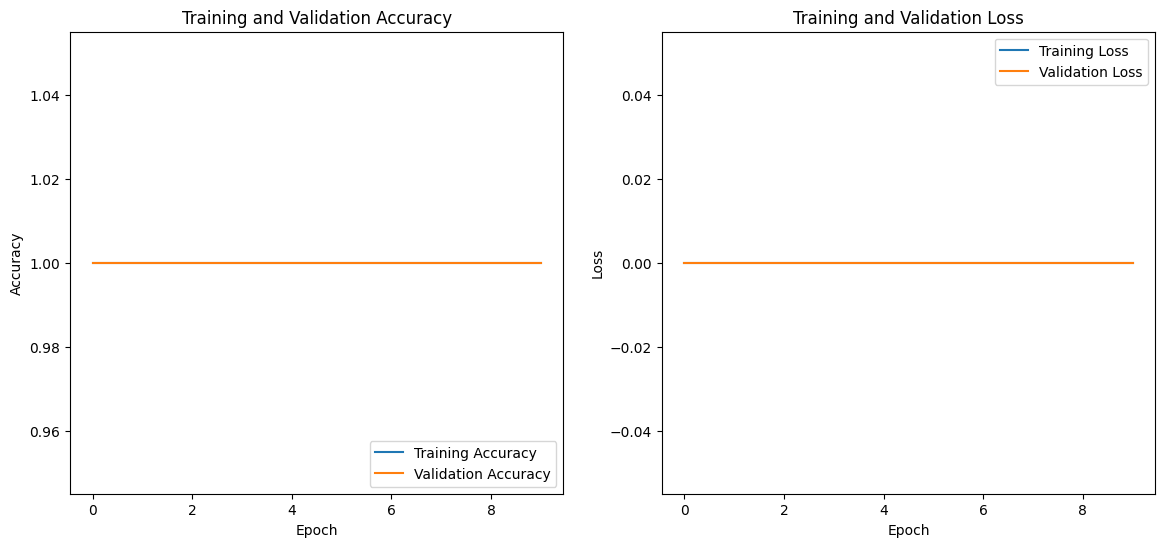

In [ ]:
if train_ds:
    num_classes = len(class_names)

    # Build the model
    model = build_model(num_classes)

    # Train the model
    print("\nStarting training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS
    )
    print("\nTraining finished!")

    # Save the final model
    model.save(MODEL_PATH)
    print(f"Model saved to '{MODEL_PATH}'. You can download it from the file browser on the left.")

    # ---
    # ## 6. Visualize Training Results
    # ---
    # Let's plot the accuracy and loss to see how well our model learned.

    acc = history.history['accuracy']
    # CORRECTED KEY: Changed 'validation_accuracy' to 'val_accuracy'
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

else:
    print("\nCould not train the model because the dataset was not loaded.")